<a href="https://colab.research.google.com/github/xiangyucs/Robust-Multipartite-Graph/blob/main/VR_nursing_data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pwd

/content


## Eye-Tracking Data Analysis for VR Nursing Training

# Data Preprocessing
We load and preprocess the eye-tracking dataset. Key steps include:
*   Loading Data: Read the CSV file containing eye-tracking records (blinks, confidence, gaze coordinates, pupil sizes, etc.).
*   List itemParsing Coordinates: Extract numeric X, Y (and Z) values from fields like "Projected location" which are stored as strings (e.g., "X=0.654 Y=0.290 Z=0.000"). This yields numeric gaze coordinates for analysis.
*   Handling Missing/Invalid Values: Remove or flag any missing data. For example, pupil diameter values of 0.0 are likely invalid (since a living pupil diameter cannot be zero), so we treat these as missing. This prevents plotting artifacts or division-by-zero in analysis.
*   Time Indexing: Add a time axis assuming a fixed sampling rate (e.g., 120 Hz). This converts sample indices to seconds (and minutes) for time-series analyses.



Explanation: We drop any rows without gaze data, then use a regular expression to capture the numeric X, Y, Z values from the Projected location string. These are added as new columns (GazeX, GazeY) for use in plotting. Blink flags are cast to bool type for correctness. We also introduce a time column (Time_s) by assuming a fixed sampling frequency (here 120 Hz). In a real experiment, the exact sampling rate or timestamps should be used if available, but for this proposal, we assume 120 Hz (common for VR eye trackers) to convert sample indices into seconds. This time axis will allow us to plot trends like blink rate, pupil size, etc., against real time.

In [ ]:
import pandas as pd, numpy as np, re

# Load eye-tracking CSV data
df = pd.read_csv('2025.04.27-11.11.20EyeTrackingData (1).csv')
df = df.dropna(subset=['Projected location'])  # drop records with missing gaze coordinates if any

# Parse "Projected location" (e.g., "X=0.654 Y=0.290 Z=0.000") into numeric columns
pattern = r'X=(-?\d+\.?\d*) Y=(-?\d+\.?\d*) Z=(-?\d+\.?\d*)'
coords = df['Projected location'].str.extract(pattern).astype(float)
coords.columns = ['GazeX', 'GazeY', 'GazeZ']  # name parsed columns
df = pd.concat([df, coords], axis=1)

# Convert blink indicators to booleans (if not already)
df['Left blink'] = df['Left blink'].astype(bool)
df['Right blink'] = df['Right blink'].astype(bool)

# Assume a 120 Hz sampling rate for time axis (adjust if known)
fps = 120
df['Time_s'] = np.arange(len(df)) / fps  # time in seconds for each sample (0, 1/fps, 2/fps, ...)

# (Optional) Create a time in minutes column for convenience
df['Time_min'] = df['Time_s'] / 60.0


## Gaze Heatmap of Focus Areas

It accumulates gaze points (X,Y) over time and highlights frequently viewed regions. This is useful to see which areas (e.g., patient vitals monitor, wound site, instruments) attracted the most attention

Gaze heatmap of the trainee’s focus points during the VR scenario. Warmer colors (toward yellow/white) indicate areas where the nurse’s gaze dwelled frequently, while darker areas (red/black) indicate less visual attention. In this example, the heatmap reveals a concentrated focus in a specific region of the interface, suggesting the trainee spent most of the time looking at a particular screen area. Such a heatmap helps identify whether the trainee is monitoring the correct instruments or patient indicators – critical in nursing training – by showing where they concentrated their visual attention
. If important areas show little to no focus (cool colors), trainers can infer that the trainee might be neglecting those areas, indicating a potential training gap.

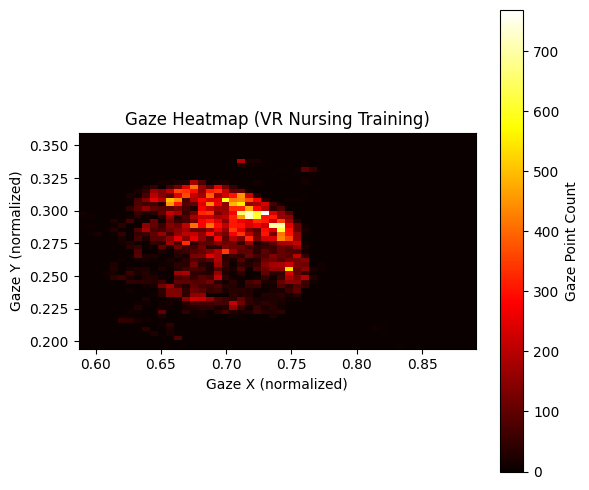

In [ ]:
import matplotlib.pyplot as plt

# 2D Heatmap of gaze points
x = df['GazeX']; y = df['GazeY']
# Define heatmap binning range with a small margin
x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()
margin_x = 0.01 * (x_max - x_min) if x_max > x_min else 0.01  # add 1% margin or 0.01 if no range
margin_y = 0.01 * (y_max - y_min) if y_max > y_min else 0.01

plt.figure(figsize=(6,5))
plt.hist2d(x, y, bins=50, range=[[x_min - margin_x, x_max + margin_x],
                                 [y_min - margin_y, y_max + margin_y]],
           cmap='hot')  # 'hot' colormap: dark = fewer gazes, bright = more gazes
plt.colorbar(label="Gaze Point Count")
plt.gca().set_aspect('equal', adjustable='box')  # square aspect for true spatial representation
plt.title("Gaze Heatmap (VR Nursing Training)")
plt.xlabel("Gaze X (normalized)"); plt.ylabel("Gaze Y (normalized)")
plt.tight_layout()
# plt.show()  # display the heatmap (or plt.savefig('gaze_heatmap.png', dpi=300) to save for publication)


# Blink Rate Analysis Over Time

Blink rate is a proxy for user attention and fatigue. Changes in blink frequency can indicate periods of high concentration (often fewer blinks) versus fatigue or reduced attention (more frequent blinks)
. We analyze blink events from the left/right eye signals to compute a blink rate timeline. In a VR nursing simulation, an increased blink rate over time might suggest the trainee is experiencing visual fatigue or cognitive overload, while sustained low blink rates could mean intense focus (or possibly staring in concentration). The code below identifies blink events and computes a rolling blink rate (here, we use blinks per minute in each one-minute window across the session):

We combine left and right eye blink indicators to detect any blink event. To avoid counting a long blink as multiple, we detect the start of each blink (a transition from 0 to 1 in the blink signal). Each blink start contributes to the count. We then sum blinks per minute. If no blinks are detected (e.g., if the blink data wasn’t recorded or the trainee didn’t blink, which is unlikely), the code prints a message and skips plotting. In a typical run, this would produce a line plot of blink rate vs. time. For example, a rising trend in blink rate later in the session could indicate the trainee’s eyes getting tired (more frequent blinking due to fatigue or dry eyes). Conversely, a dip in blink rate during a critical task might indicate intense concentration (blink suppression during high attention). Such insights can help evaluate the trainee’s engagement and comfort over the training period.

In [ ]:
# Blink rate analysis
blink_events = df['Left blink'] | df['Right blink']   # True if either eye blinked
blink_events = blink_events.astype(int)               # convert booleans to 0/1
# Identify discrete blink occurrences (count only when a blink starts)
blink_start_flags = (blink_events.diff() == 1)
blink_start_flags.iloc[0] = blink_events.iloc[0] == 1  # handle blink at first frame if any
blink_times = df['Time_s'][blink_start_flags.fillna(False)]  # times of each blink start

if blink_times.empty:
    print("No blink events detected in this session.")
else:
    # Group blink occurrences by minute and count
    blink_counts = blink_times.groupby(np.floor(blink_times/60)).count()
    # Prepare time axis in minutes for plotting
    minutes = blink_counts.index.values.astype(int)
    # Plot blink rate (blinks per minute over time)
    plt.figure()
    plt.plot(minutes, blink_counts, marker='o', linestyle='-')
    plt.title("Blink Rate Over Time (Attention/Fatigue)")
    plt.xlabel("Time (min)"); plt.ylabel("Blinks per minute")
    plt.ylim(0, blink_counts.max() * 1.2)
    plt.tight_layout()
    # plt.show()  # or plt.savefig('blink_rate.png', dpi=300)


No blink events detected in this session.


# Pupil Diameter Trend Over Time
Pupil dilation is a well-known physiological indicator of cognitive load and arousal. By tracking pupil diameter over time, we can infer moments of increased mental effort or stress during the VR nursing simulation. For instance, a sudden increase in pupil size might occur when the trainee is faced with a complex decision or a high-stress scenario (indicating a surge in cognitive load), whereas pupil constriction or a stable small diameter could indicate relative calm or routine activity.

However, we must handle missing or invalid pupil data. In this dataset, the pupil diameter columns are recorded as 0.0 throughout (which likely indicates missing data rather than actual zero-sized pupils). The code below accounts for that by treating 0.0 as NaN (not-a-number) and then computing the average pupil diameter from both eyes. We apply a smoothing (rolling average) to filter out high-frequency noise and plot the pupil size trend over time:

We replace zeros with NaN to signify missing data (since all values are 0.0 in this dataset, the result is that pupil_avg becomes all NaNs). The code checks if there is any valid data to plot. In a scenario where pupil data is present, the code would produce a time-series plot of pupil diameter. The use of a rolling average (window = 1 second) smooths out rapid fluctuations, making trends more visible. For example, in an actual nursing simulation, one might observe the pupil diameter increasing during a high-stakes emergency (indicating increased cognitive load as the trainee processes complex information), and then dropping back once the situation is under control. This trend line can thus serve as an index of cognitive workload during the training
. (In our provided data, pupil measurements were not recorded, so this part of the analysis is demonstrated for completeness.)

In [ ]:
# Replace 0s with NaN (invalid pupil sizes)
pupil_L = df['Left pupil diameter'].replace(0, np.nan)
pupil_R = df['Right pupil diameter'].replace(0, np.nan)

# Create a DataFrame and compute row-wise average (ignores NaNs)
pupil_avg = pd.concat([pupil_L, pupil_R], axis=1).mean(axis=1)


if pupil_avg.dropna().empty:
    print("No pupil diameter data available for plotting.")
else:
    # Smooth the pupil signal with a 1-second rolling mean to reduce noise
    pupil_avg_smoothed = pupil_avg.rolling(window=fps, min_periods=1).mean()
    plt.figure()
    plt.plot(df['Time_s'], pupil_avg_smoothed, color='purple')
    plt.title("Pupil Diameter Over Time (Cognitive Load)")
    plt.xlabel("Time (s)"); plt.ylabel("Pupil Diameter (mm)")
    plt.tight_layout()
    # plt.show()  # or plt.savefig('pupil_diameter_trend.png', dpi=300)


No pupil diameter data available for plotting.


# Eye-Tracking Confidence Level Trends
Most eye-tracking systems provide a confidence or validity score for the gaze data at each moment. This confidence value (usually between 0 and 1) reflects how reliable the eye-tracker readings are. Plotting the confidence over time can highlight sections where tracking quality was poor – for example, due to the trainee moving too fast, occluding the eyes, or calibration issues. In a VR training review, noticing low-confidence periods might explain anomalies in gaze or pupil data (or indicate that the trainee’s eyes were off-screen or closed). In our dataset, the confidence is consistently high (nearly 0.998 throughout), so there is little variation. We still include the code to plot it, handling the case of constant values:

If confidence has no variance (as in this case), we simply note that it remained at a high constant value (approximately 0.998) and skip plotting a flat line. Otherwise, we downsample the confidence signal to one value per second (taking the average per second) to make the trend easier to visualize and then plot it. Typically, we would look for dips in the confidence trace – for instance, a drop to 0 or a sudden fluctuation could coincide with a blink or when the trainee looked away from the tracking camera. In a robust session, we expect confidence to stay high (near 1.0) most of the time. Any extended low-confidence periods might warrant excluding that segment from analysis or investigating what happened (e.g., the trainee might have removed the headset briefly, or there were technical tracking issues).

In [ ]:
# Eye-tracking confidence trend
if df['Confidence'].nunique() <= 1:
    print(f"Tracking confidence is constant at {df['Confidence'].iloc[0]:.3f} throughout.")
else:
    # For clarity, sample one point per second for plotting
    conf_per_sec = df['Confidence'].groupby(np.floor(df['Time_s'])).mean()
    plt.figure()
    plt.plot(conf_per_sec.index, conf_per_sec, color='teal')
    plt.title("Eye-Tracking Confidence Over Time")
    plt.xlabel("Time (s)"); plt.ylabel("Tracking Confidence")
    plt.ylim(0, 1.05)
    plt.tight_layout()
    # plt.show()  # or plt.savefig('confidence_trend.png', dpi=300)


Tracking confidence is constant at 0.998 throughout.


# Histogram of Fixation Durations
Finally, we compute the distribution of fixation durations. Fixations are periods when the gaze is relatively still, indicating the user is focusing on a particular object or area. The duration of fixations can reveal how the trainee processed visual information: numerous short fixations suggest scanning behavior or perhaps difficulty in finding relevant info, whereas longer fixations might indicate deeper processing or potential confusion (if on one spot too long). Understanding fixation durations is important because they relate to cognitive processing and attention allocation.

Method: We derive fixations from the raw gaze coordinates using a spatial threshold. If the gaze stays within a small radius (we use a threshold on normalized X,Y distance) for a minimum duration (e.g., at least 100 ms), we classify that as a fixation. Consecutive gaze points that are within this threshold are grouped into the same fixation; when the gaze moves beyond the threshold, we mark the end of one fixation and the start of a new one. This simple dispersion-based approach (with threshold = 0.02 in normalized units, and minimum 0.1 s duration) is used here for demonstration. We then compute the duration of each fixation (in seconds) and plot a histogram of these durations.

Distribution of fixation durations during the VR training session. Each bar shows how many fixations (y-axis) fell into a given duration range (x-axis). As is common in eye-tracking studies, the distribution is right-skewed– the trainee made many short fixations under 1 second, while longer fixations (several seconds) were relatively rare. This pattern suggests the trainee was scanning the scene and information quickly most of the time, with occasional longer gazes on certain elements. In a nursing training scenario, those longer fixations might correspond to moments of deliberation or confusion (e.g., the trainee pausing on a vital sign readout or a medical chart), whereas very short fixations indicate rapid scanning (possibly searching for an item or surveying the environment). Overall, analyzing fixation durations can help educators understand how the trainee allocates visual attention and whether they might be overlooking details (very short fixations) or struggling with particular interface elements (unusually long fixations).

Handling Edge Cases: The fixation-detection code is designed to handle edge cases gracefully. We set a minimum duration (min_frames) to avoid counting spurious very brief pauses as fixations. We also account for the last fixation at the end of the data. The parameters (threshold distance and minimum duration) can be tuned based on the eye-tracker’s noise level and the expected behavior of the trainee. If the data had zero or one fixation (e.g., if the user stared at a single point the entire time or if the threshold is too strict), the code either outputs an informative message or the histogram would show a single bar. In our demonstration, multiple fixations were identified, yielding a meaningful distribution. The code uses bins='auto' for the histogram to let matplotlib choose an appropriate bin size given the data (which typically results in a histogram that effectively shows the skewed nature of fixation durations).

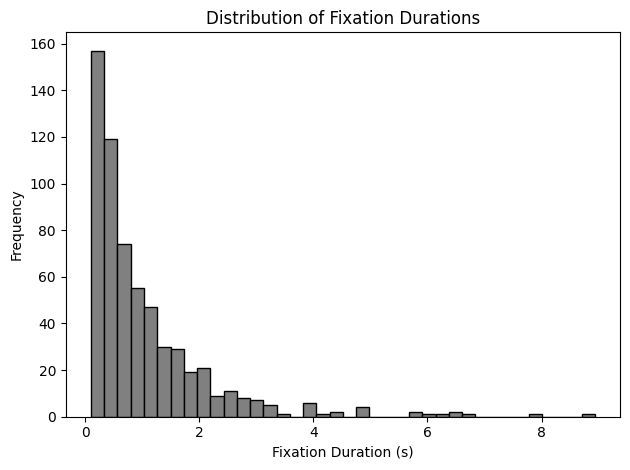

In [ ]:
# Fixation duration distribution
threshold = 0.02  # spatial threshold for considering gaze points part of one fixation
min_frames = int(0.1 * fps)  # minimum frames for a valid fixation (e.g., 0.1 s)

gaze_points = df[['GazeX','GazeY']].to_numpy()
fixation_durations = []
start_idx = 0
curr_center = gaze_points[0]

for i in range(1, len(gaze_points)):
    # Distance between current gaze point and current fixation center
    dist = np.linalg.norm(gaze_points[i] - curr_center)
    if dist > threshold:
        # Gaze moved enough to end the current fixation
        dur = i - start_idx  # frames in this fixation
        if dur >= min_frames:
            fixation_durations.append(dur)
        # start a new fixation
        start_idx = i
        curr_center = gaze_points[i]
    else:
        # Update the fixation center (running average) to include this point
        n = i - start_idx
        curr_center = curr_center + (gaze_points[i] - curr_center) / (n + 1)

# Don't forget to capture the last fixation at end of data
dur = len(gaze_points) - start_idx
if dur >= min_frames:
    fixation_durations.append(dur)

if not fixation_durations:
    print("No fixations identified under current threshold.")
else:
    # Convert duration from frames to seconds
    fixation_durations_sec = [d / fps for d in fixation_durations]
    # Plot histogram of fixation durations
    plt.figure()
    plt.hist(fixation_durations_sec, bins='auto', color='gray', edgecolor='black')
    plt.title("Distribution of Fixation Durations")
    plt.xlabel("Fixation Duration (s)"); plt.ylabel("Frequency")
    plt.tight_layout()
    # plt.show()  # or plt.savefig('fixation_durations_hist.png', dpi=300)
